# 读取数据集
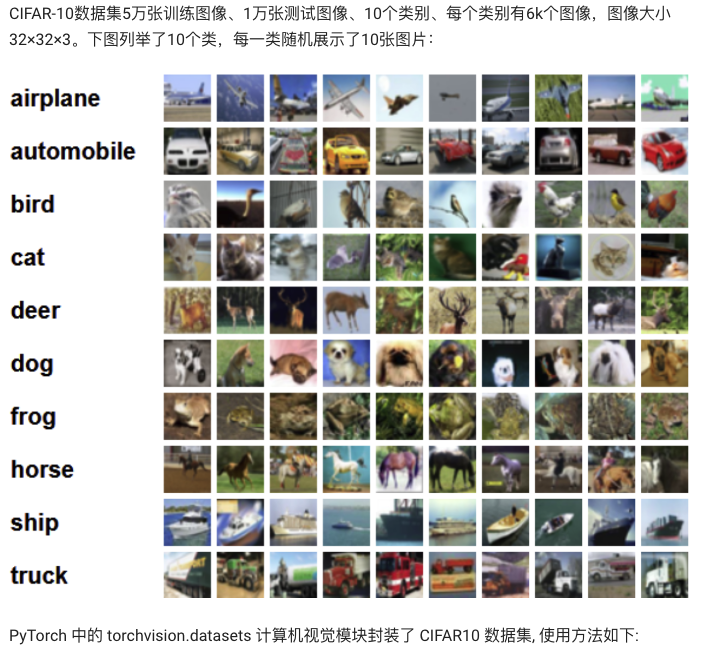

In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# 1. 数据集基本信息
def test01():
    # 加载数据集
    train = CIFAR10(root='./data', train=True, download=True, transform=Compose([ToTensor()]))
    valid = CIFAR10(root='./data', train=True, download=True, transform=Compose([ToTensor()]))
    
    # 数据集数量
    print('训练集数量：',len(train.targets))
    print('测试集数量:', len(valid.targets))

    # 数据集形状
    print("数据集形状:", train[0][0].shape)

    # 数据集类别
    print("数据集类别:", train.class_to_idx)


# 2. 数据加载器
def test02():

    train = CIFAR10(root='./data', train=True, transform=Compose([ToTensor()]))
    dataloader = DataLoader(train, batch_size=8, shuffle=True)
    for x, y in dataloader:
        print(x.shape)
        print(y)
        break


if __name__ == '__main__':
    test01()
    test02()

100%|██████████| 170498071/170498071 [10:36<00:00, 267918.62it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
训练集数量： 50000
测试集数量: 50000
数据集形状: torch.Size([3, 32, 32])
数据集类别: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.Size([8, 3, 32, 32])
tensor([7, 6, 7, 7, 3, 2, 1, 4])


# 2. 搭建图像分类网络
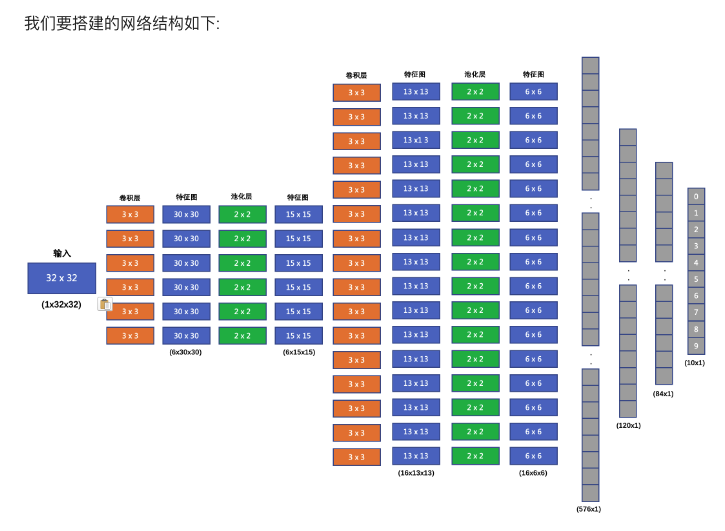

In [2]:
from torch import nn
import torch.nn.functional as F

class ImageClassification(nn.Module):
    def __init__(self):
        super(ImageClassification, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, stride = 1,kernel_size = 3) # 第一个卷积层输入 3 个 Channel, 输出 6 个 Channel, Kernel Size 为: 3x3
        self.pool1 = nn.MaxPool2d(kernel_size = 2 , stride = 2) # 第一个池化层输入 30x30, 输出 15x15, Kernel Size 为: 2x2, Stride 为: 2
        self.conv2 = nn.Conv2d(6, 16,stride = 1,kernel_size = 3) # 第二个卷积层输入 6 个 Channel, 输出 16 个 Channel, Kernel Size 为 3x3
        self.pool2 = nn.MaxPool2d(kernel_size = 2,stride = 2) # 第二个池化层输入 13x13, 输出 6x6, Kernel Size 为: 2x2, Stride 为: 2
        
        self.linear1 = nn.Linear(576,120) # 第一个全连接层输入 576 维, 输出 120 维
        self.linear2 = nn.Linear(120,84) # 第二个全连接层输入 120 维, 输出 84 维
        self.out = nn.Linear(84,10) # 最后的输出层输入 84 维, 输出 10 维
        
    def forward(self,x):
        x = F.relu(self.conv1(x)) # 在每个卷积计算之后应用 relu 激活函数来给网络增加非线性因素
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # 由于最后一个批次可能不够32，所以需要根据批次数量来 flatten
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        return self.out(x)
    

# 3. 编写训练函数
我们的训练时，使用多分类交叉熵损失函数，Adam 优化器. 具体实现代码如下:

In [ ]:
import torch
import torch.optim as optim
import time

def train():
    # 加载CIFAR10 训练集，并将其转换为张量
    transgform = Compose([ToTensor()])
    cifar10 = CIFAR10(root='./data',train=True,download=True,transform=transgform)
    
    # 构建图像分类模型
    model = ImageClassification()
    # 构建损失函数
    criterion = nn.CrossEntropyLoss()
    # 构建优化方法
    optimizer = optim.Adam(model.parameters(),lr=1e-3) # le-3 = 0.001
    # 训练轮数
    epoch = 100
    # 批次数
    BATCH_SIZE = 32
    
    for epoch_idx in range(epoch):
        
        # 构建数据加载器
        dataloader = DataLoader(cifar10,batch_size=BATCH_SIZE,shuffle=True)
        # 样本数量
        sam_num = 0
        # 损失总和
        total_loss = 0.0
        # 开始时间
        start = time.time()
        # 正确样本数
        correct = 0
        
        for x,y in dataloader:
            # 送入模型
            output = model(x)
            # 计算损失
            loss = criterion(output,y)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
            
            # 统计分类正确的样本数量
            correct += (torch.argmax(output,dim=-1) == y).sum()
            total_loss += (loss.item()*len(y))
            sam_num += y
            
        print('epoch:%2s loss:%.5f acc:%.2f time:%.2fs' %
              (epoch_idx + 1,
               total_loss / sam_num,
               correct / sam_num,
               time.time() - start))
        

        # 序列化模型
    torch.save(model.state_dict(), './model/image_classification.bin')    

# 4.编写预测函数
我们加载训练好的模型，对测试集中的 1 万条样本进行预测，查看模型在测试集上的准确率.

In [5]:
def test():
    BATCH_SIZE = 32
    # 加载cifar10 测试集，并将其转换为张量
    transgform = Compose([ToTensor()])
    cifar10 = CIFAR10(root='./data',train=False,download=True,transform=transgform)
    # 构建数据加载器
    dataloader = DataLoader(cifar10,batch_size=BATCH_SIZE,shuffle=True)
    # 加载模型
    model = ImageClassification()
    model.load_state_dict(torch.load('./model/image_classification.bin'))
    model.eval()
    
    total_correct = 0
    total_samples = 0
    for x, y in  dataloader:
        output = model(x)
        total_correct += (torch.argmax(output, dim=-1) == y).sum()
        total_samples += len(y)

    print('Acc: %.2f' % (total_correct / total_samples))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# 5.优化网络
1. 增加卷积核输出通道数
2. 增加全连接层的参数量
3. 调整学习率
4. 调整优化方法
5. 修改激活函数
6. 等等..

In [6]:
class ImageClassification(nn.Module):


    def __init__(self):

        super(ImageClassification, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, stride=1, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 128, stride=1, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear1 = nn.Linear(128 * 6 * 6, 2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.out = nn.Linear(2048, 10)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # 由于最后一个批次可能不够 32，所以需要根据批次数量来 flatten
        x = x.reshape(x.size(0), -1)

        x = F.relu(self.linear1(x))
        x = F.dropout(x, p=0.5)

        x = F.relu(self.linear2(x))
        x = F.dropout(x, p=0.5)

        return self.out(x)